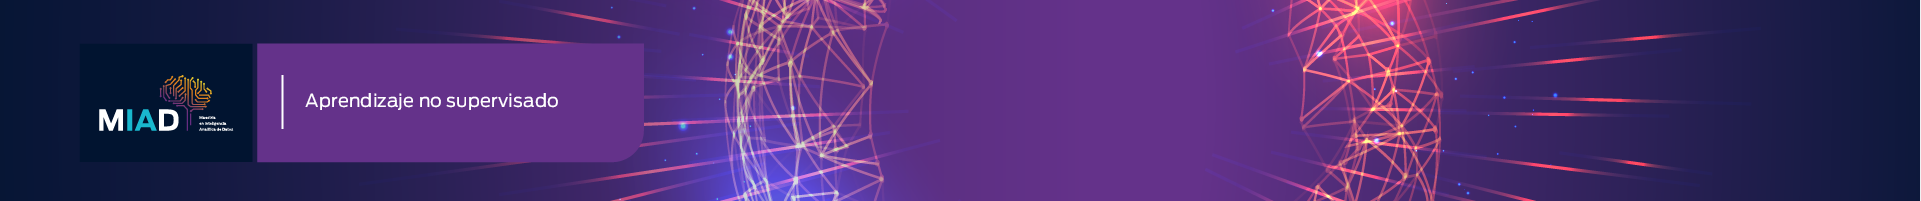

# Semana 8. Sesión Sincrónica.


El  *cuaderno* tiene como objetivo introducir a los estudiantes a estimaciones de densidad utilizando el Modelo de Mezclas Gausianas y resolver preguntas del taller de la semana 7.


**NO** es necesario editar el archivo o hacer una entrega. Los ejemplos contienen celdas con código ejecutable (`en gris`), que podrá modificar libremente. Esta puede ser una buena forma de aprender nuevas funcionalidades del *cuaderno*, o experimentar variaciones en los códigos de ejemplo.



In [ ]:
# Librerias
!pip install geopandas
!pip install geopy
!pip install seaborn
!pip install folium
!pip install bokeh
!pip install geojsoncontour
!pip install pyrosm

from google.colab import drive
drive.mount('/content/drive')


# Estimacion de densidades

La estimación de densidad camina la delgada linea la línea entre el aprendizaje no supervisado, la ingeniería de características (feature engineering) y el modelado de datos.


## Para que sirve?


$X_1, \dots X_n \sim_{iid} F$ con densidad $f$


El objetivo es estimar la densidad $f$ con $\hat{f}$


En este curso nos centraremos en dos de las técnicas más populares:

 - Estimacion de densidad de Kernel (no paramétrico)
 - Modelos de Mezclas Gausianes (MMG) (paramétrico)





## Métodos no paramétricos


- Buscan estimar $f(x)$ sin asumir una forma funcional particular, sólo suponiendo ciertas condiciones de regularidad de la densidad (suavidad, diferenciabilidad)


-  ¿Cómo se interpreta la información muestral?


-  Si observamos más datos “cerca” de $x$ que de $x'$ inferimos que $f(x )> f(x') $

## Métodos Paramétricos

Asumen una forma funcional para $f$ :


  \begin{align}
  f\left(x_o\right)=\phi\left(x_o\right)=\frac{1}{\sigma\sqrt{2\ \pi}}\exp{\left\lfloor-\ \frac{1}{2}\left(\frac{x_o-\mu}{\sigma}\right)^2\right\rfloor}
  \end{align}

  La ignorancia sobre $f\left(x_o\right)$ se limita a la ignorancia de dos parámetros $\mu$ and $\sigma$

  

# Análisis del delito en Chicago



## Descripción de datos




### Delitos

In [ ]:
import pandas as pd
import numpy as np

dta = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/Chicago_delitos_verano_2019.csv')
dta.head()

### Barrios de Chicago

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point


barrios = gpd.read_file('/content/drive/My Drive/Colab Notebooks/data/Areas_comunitarias_Chicago.zip')

barrios.head()

In [ ]:
barrios=barrios.rename(columns={'area_numbe': "nro_area_comunitaria"})
barrios["nro_area_comunitaria"]=barrios["nro_area_comunitaria"].astype(int)
barrios.head()

In [ ]:

import folium

map = folium.Map(location = [41.881998,-87.627800], tiles = "OpenStreetMap", zoom_start = 10)


#Agregamos la capa de polígonos con un popup con el nombre del area comunitaria
for _, r in barrios.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#FFFFFF'})
    folium.Popup(r['community']).add_to(geo_j)
    geo_j.add_to(map)

map

In [ ]:
# Table of tipo de crimen por barrio
crimen_barrio = pd.crosstab(index=dta["nro_area_comunitaria"],
                           columns=dta["tipo_crimen"],
                           margins=True)



perc_crimen=crimen_barrio/crimen_barrio.iloc[77,:]
perc_crimen=perc_crimen.rename(columns={'homicidio': "homicidio_perc",'robo': "robo_perc",'All': "All_perc"})

df_barrios=barrios[['nro_area_comunitaria','community']]
df_barrios=df_barrios.merge(perc_crimen, on='nro_area_comunitaria', how='left')
df_barrios=df_barrios.merge(crimen_barrio, on='nro_area_comunitaria', how='left')
df_barrios

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8), dpi = 100)
df_barrios.plot.bar(ax=ax,x='community', y='robo', rot=90)

In [ ]:
gdf  = df_barrios.merge(barrios, on='nro_area_comunitaria', how='left')
gdf = gpd.GeoDataFrame(gdf)
fig, ax = plt.subplots(figsize = (10, 8), dpi = 100)
gdf.plot(ax = ax, column='robo_perc' ,edgecolor = 'black', legend = True, cmap='OrRd');


In [ ]:
fig, ax = plt.subplots(figsize = (14, 8), dpi = 100)
df_barrios.plot.bar(ax=ax,x='community', y='homicidio', rot=90)

In [ ]:
sns.regplot(x='robo',y='homicidio',data=df_barrios, ci=None)

In [ ]:
from statsmodels.formula.api import ols

simple = ols("homicidio ~ robo", data = df_barrios).fit()
print(simple.summary())

## Estimación de puntos calientes

- El análisis de puntos de puntos calientes se busca encontrar áreas donde hay más concentración de puntos de datos,


- Es similar a DBSCAN pero vamos a usar un enfoque que viene de la estadistíca: estimación de densidades.


- Cuando los datos son geográficos, nos encontramos en dos dimensiones. Es decir, la frecuencia está ahora determinada por dos variables: longitud y latitud.




### Densidades de kernel bivariadas

- Teóricamente podemos usar y extender el mismo principio de la estimación de densidad de kernel univariada estudiada anteriormente para cualquier tipo de densidades. En el caso bidimensional con datos iid, esta expresión se resume a:

\begin{align}
    \hat{f}(x,y) = \frac{1}{nh_xh_y}\sum_{i=1}^n K\left(\frac{X_i-x}{h_x}\right)K\left(\frac{Y_i-x}{h_y}\right)
  \end{align}

#### Robos

In [ ]:
#Cargamos la librería
import geopandas as gpd
import statsmodels.api as sm

# Ponemos como datos espaciales
db = gpd.GeoDataFrame(dta, geometry = gpd.points_from_xy(dta.lon, dta.lat))
db.crs = "EPSG:4326"
db.head()



robos = db[db.tipo_crimen=='robo'][["lat", "lon"]]

# val cruzada
#dens_robos_cv_ml = sm.nonparametric.KDEMultivariate(data=robos, var_type='cc', bw='cv_ml')
dens_robos_normal_reference = sm.nonparametric.KDEMultivariate(data=robos, var_type='cc', bw='normal_reference')


In [ ]:
# Grilla de valores dentro del rango observado (2 dimensiones)
x = np.linspace(barrios.total_bounds[0], barrios.total_bounds[2], 300)
y = np.linspace(barrios.total_bounds[1], barrios.total_bounds[3], 300)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack(( yy.flatten(),xx.flatten()))


In [ ]:
f_hat_robos_normal_reference=dens_robos_normal_reference.pdf(data_predict=grid)

In [ ]:
import geojsoncontour


contourf_normal_reference = plt.contourf(xx, yy, f_hat_robos_normal_reference.reshape(xx.shape),
    alpha =0.9, linestyles='None')

geojson_normal_reference = geojsoncontour.contourf_to_geojson(
    contourf=contourf_normal_reference,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

In [ ]:
folium.GeoJson(
    geojson_normal_reference,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
         'fillColor': x['properties']['fill'],
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(map)

map

#### Homicidios

In [ ]:
homicidios = db[db.tipo_crimen=='homicidio'][["lat", "lon"]]


dens_homicidios_normal_reference = sm.nonparametric.KDEMultivariate(data=homicidios, var_type='cc', bw='normal_reference')

f_hat_homicidios_normal_reference=dens_homicidios_normal_reference.pdf(data_predict=grid)



contourf_normal_reference = plt.contourf(xx, yy, f_hat_homicidios_normal_reference.reshape(xx.shape),
    alpha =0.9, linestyles='None')

geojson_normal_reference = geojsoncontour.contourf_to_geojson(
    contourf=contourf_normal_reference,
    min_angle_deg=3.0,
    ndigits=5,
    stroke_width=1,
    fill_opacity=0.5)

In [ ]:

map = folium.Map(location = [41.881998,-87.627800], tiles = "OpenStreetMap", zoom_start = 10)


#Agregamos la capa de polígonos con un popup con el nombre del area comunitaria
for _, r in barrios.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#FFFFFF'})
    folium.Popup(r['community']).add_to(geo_j)
    geo_j.add_to(map)
folium.GeoJson(
    geojson_normal_reference,
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
         'fillColor': x['properties']['fill'],
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(map)

map

## Modelo de mezclas gaussianas

Formalmente, en los modelos de mezclas gaussianas describimos la función de densidad como:

\begin{align}
f( x| \theta) &= \sum_{k=1}^K \pi_k N( x|  \mu_k,  \Sigma_k)\\
\pi_k &\geq 0 \\
\sum_{k=1}^K\pi_k &= 1
\end{align}


Donde $\theta=\{ \mu_k,  \Sigma_k, \pi_k\ \}$ con $k=1,...,K$ son los parámetros de la densidad.
En este ejemplo tenemos algo asi:

\begin{align}
f( x| \theta)=\color{blue}{\pi_1*N( x|  \mu_1,  \Sigma_1)} + \color{orange}{\pi_2*N( x|  \mu_2,  \Sigma_2)} + \color{green}{\pi_3*N( x|  \mu_3,  \Sigma_3)}
\end{align}


Recordemos que

\begin{align}
N(x \mid \mu,\Sigma) = \frac{1}{(2\pi)^{d/2}\sqrt{|\Sigma|}}exp(-\dfrac{1}{2}(x-\mu)^{T}\Sigma^{-1}(x-\mu))
\end{align}

En el caso de dos dimensiones esta luce
\begin{align}
N
\begin{bmatrix}
\begin{pmatrix}
\mu_1\\
\mu_2
\end{pmatrix}\, ,
\begin{pmatrix}
\sigma^2_1 & \sigma_{12} \\
\sigma_{21} & \sigma^2_2
\end{pmatrix}
\end{bmatrix}
\end{align}

El vector de medias, que contiene los elementos $\mu_1$ y $𝜇_2$, centra la distribución a lo largo de cada dimensión. Por otro lado, la matriz de covarianza especifica la extensión y orientación de la distribución.

A lo largo de la diagonal de esta matriz de covarianza tenemos los términos de varianza $\sigma^2_1$ y $\sigma^2_2$ que representan la forma (dispersión) a lo largo de cada una de las dimensiones. Pero también tenemos los términos fuera de la diagonal, $\sigma_{12}$ y $𝜎_{21}$ que especifican la estructura de correlación de la distribución.

Veamos algunos ejemplos de estructuras de covarianza que podríamos especificar.

In [ ]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, multivariate_normal

# http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
x, y = np.mgrid[-4:4:.01, -4:4:.01]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y

# different values for the covariance matrix
covariances = [ [[1, 0], [0, 1]], [[1, 0], [0, 3]], [[1, -1], [-1, 3]] ]
titles = ['spherical', 'diag', 'full']

plt.figure(figsize = (15, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    z = multivariate_normal([0, 0], covariances[i]).pdf(position)
    plt.contour(x, y, z)
    plt.title('{}, {}'.format(titles[i], covariances[i]))
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])

plt.show()

### Algoritmo EM

Para la estimación de los parámetros utilizamos el algoritmo EM (*Expectation — Maximization algorithm*) que fue propuesto por Dempster et al.(1977).

Los pasos del algoritmo para MMG son:

   1. Iniciar $\mu_k$, $\Sigma_k$ y $\pi_k$.
   2. *Paso-E*: evaluar las responsabilidades $r_{ik}$ para cada punto de datos usando los parámetros actuales.
   \begin{align}
r_{ik} = \frac{\pi_{k}N(x_{i}|\mu_{k},\Sigma_{k})}{\sum_{k=1}^{K}\pi_{k}N(x_{i}|\mu_{k},\Sigma_{k})}
\end{align}
   3. *Paso-M*: re-estimar los parámetros $\mu_k$, $\Sigma_k$ y $\pi_k$ usando las responsabilidades $r_{ik}$ encontradas en el paso anterior.
   4. Iterar hasta la convergencia de la función de log-verosimilitud. La forma de esta nos garantiza que siempre alcanzaremos al menos un mínimo local.


\begin{align}
l &=\log f(X|\theta) \\
&=\sum_{n=1}^{N}\log\sum_{k=1}^{K}\pi_{k}N(x_{i}|\mu_{k},\Sigma_{k})
\end{align}

   

- Estimemos

In [ ]:
homicidios.iloc[:,0]

In [ ]:
from sklearn.mixture import GaussianMixture

MMG_homicidios = GaussianMixture(n_components = 2, covariance_type='full', random_state = 1234).fit(homicidios)


In [ ]:
#Definimos una función que nos permite crear las curvas de nivel a través de elipses:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Dibuja un elipse dado la media y varianza"""
    ax = ax or plt.gca()

    # Convierte las covarianzas
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Dibuja el elipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X.iloc[:, 0], X.iloc[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [ ]:
# Graficamos
plot_gmm(MMG_homicidios, homicidios)

## ¿Cuántos componentes?

- El hecho de que MMG sea un modelo probabilístico simplifica esta tarea. Podemos usar la medida natural dada por la log verosimilitud.

- Sin embargo no queremos sobreajustar y podemos regularizar usando

     
\begin{align}
     AIC= - 2 Log(L) + 2 d
\end{align}

penaliza por el número de paramétros a estimar o
     
\begin{align}
     BIC= - 2 Log(L) + Log(N) d
\end{align}
     
además de penalizar por el número de paramétros a estimar penaliza también por el número de observaciones (N).

In [ ]:
n_components = np.arange(1, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(homicidios)
          for n in n_components]

plt.plot(n_components, [m.bic(homicidios) for m in models], label='BIC')
plt.plot(n_components, [m.aic(homicidios) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [ ]:
from sklearn.mixture import GaussianMixture

MMG_homicidios3 = GaussianMixture(n_components = 3, covariance_type='full', random_state = 0).fit(homicidios)

# Graficamos
plot_gmm(MMG_homicidios3, homicidios)

## ¿Qué matriz de covarianza usar?

Miramos el ajuste de los diferentes modelos y nos quedamos con el mejor modelo (el BIC más bajo). Esto se hace utilizando GridSearchCV y una función de `score` definidas por nosotros que devuelve la puntuación BIC negativa, ya que GridSearchCV está diseñado para maximizar (maximizar el BIC negativo equivale a minimizar el BIC).

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 5),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(homicidios)

In [ ]:

df_search = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_search["mean_test_score"] = df_search["mean_test_score"]
df_search = df_search.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_search.sort_values(by="BIC score").head()

In [ ]:
import seaborn as sns

sns.catplot(
    data=df_search,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [ ]:
MMG_homicidios4 = GaussianMixture(n_components = 4, covariance_type='full', random_state = 0).fit(homicidios)

# Graficamos
plot_gmm(MMG_homicidios4, homicidios)

## Explicando la ubicación del delito

El objetivo de este punto es encontrar posibles correlaciones  entre el crimen y características de la ciudad. Para ello, utilice los datos de OpenStreetMap y explore si existe una correlación entre el porcentaje del área de la comunidad  dedicado a tiendas (`retail`)  y comercios (`commercial`) y el número total de robos y homicidios en esa comunidad. Ofrezca una explicación intuitiva de por qué cree que aparecen estas correlaciones. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

- Bajando todos los datos

In [ ]:
from pyrosm import OSM, get_data

# Bajamos los datos para  Chicago
fp = get_data("chicago")

# Inicializamos el lector para Chicago
osm = OSM(fp)

In [ ]:
landuse0 = osm.get_landuse(custom_filter={'landuse': ['retail',"commercial"]})

In [ ]:
landuse = landuse0.copy()
landuse

### Correlaciones

In [ ]:
# Reproject calculate area in meters2 https://epsg.io/26916
landuse=landuse.to_crs('26916')
landuse['area_comercial']=landuse['geometry'].area

barrios=barrios.to_crs('26916')
barrios['area_total']=barrios['geometry'].area

landuse=landuse.to_crs('4386')
barrios=barrios.to_crs('4386')

union = gpd.sjoin(landuse, barrios)

landuse_area_tipo=union.groupby(['nro_area_comunitaria','landuse','area_total'], as_index=False)['area_comercial'].sum()
landuse_area_tipo=pd.DataFrame(landuse_area_tipo)
landuse_area_tipo['perc_area']=landuse_area_tipo['area_comercial']/landuse_area_tipo['area_total']
landuse_area_tipo=landuse_area_tipo.pivot_table(index=['nro_area_comunitaria'],columns="landuse", values="perc_area", fill_value=0)


df_barrios=df_barrios.merge(landuse_area_tipo, on='nro_area_comunitaria', how='left')
df_barrios['area_comercios']=df_barrios['commercial']+df_barrios['retail']
df_barrios.head()


In [ ]:
sns.regplot(x='homicidio',y='area_comercios',data=df_barrios, ci=None)

In [ ]:
homicidio = ols("area_comercios ~ homicidio", data = df_barrios).fit()
print(homicidio.summary())

In [ ]:
sns.regplot(x='robo',y='area_comercios',data=df_barrios, ci=None)

In [ ]:
robos = ols("area_comercios ~ robo", data = df_barrios).fit()
print(robos.summary())

## MMGs para Generar Nuevos Datos

La idea es mostrar cómo usar un Modelo de Mezcla Gaussiana (GMM) puede ser utilizado un modelo generativo para crear nuevas muestras a partir de la distribución definida por los datos de entrada. Para ello generaremos *nuevas cifras escritas a mano* utilizando el corpus de dígitos estándar de `sklearn`.


In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

Comencemos visualizando los primeros 50 dígitos para recordar exactamente con qué estamos trabajando (ver la figura siguiente):


In [ ]:
def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(8, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Tenemos una muestra de los primeros 50 dígitos del dataset. Cada dígito está representado por una matriz de 8x8 píxeles, donde cada valor de la matriz indica la intensidad del píxel correspondiente.


Cada dígito en este dataset está representado en un **espacio de 64 dimensiones**. Esto se debe a que cada imagen de dígito tiene 8 píxeles de ancho y 8 píxeles de alto, lo que resulta en \(8 \times 8 = 64\) características por observación. Es decir, cada dígito es un punto en un espacio de características de alta dimensión.

### Reducción de Dimensionalidad

Construir un GMM directamente en este espacio de 64 dimensiones puede ser complicado porque:

1. **Convergencia**: Los GMM pueden tener dificultades para converger en espacios de alta dimensión debido a la cantidad de parámetros que deben estimarse (medias, covarianzas y pesos de mezcla para cada componente).
2. **Sobreajuste**: Un modelo en un espacio de tan alta dimensionalidad puede sobreajustarse fácilmente a los datos de entrenamiento, lo que significa que no generalizará bien para generar nuevos dígitos.

Para abordar este problema, vamos a aplicar un **algoritmo de reducción de dimensionalidad** que sea invertible, es decir, que nos permita reducir el número de dimensiones pero también reconstruir los datos originales a partir de las dimensiones reducidas.

Utilizaremos Análisis de Componentes Principales (PCA), indicándole que preserve el 99% de la varianza en los datos proyectados:


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

Dado este nuevo conjunto de datos proyectado, vamos a utilizar el Criterio de Información de Akaike (AIC) para determinar el número adecuado de "distribuciones" en el modelo GMM:


In [ ]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

Alrededor de 140  minimizan el AIC; utilizaremos este modelo.

Ajustamos el modelo GMM con 140 componentes a los datos y confirmemos que ha convergido:


In [ ]:
gmm = GaussianMixture(140, covariance_type='full', random_state=1)
gmm.fit(data)
print(gmm.converged_)

Ahroa podemos sacar aleatoriamente 100 imagenes nuevas con este espacio proyectado.

In [ ]:
data_new, _ = gmm.sample(100)
data_new.shape


Finalmente, podemos usar la transformación inversa del objeto PCA para reconstruir los nuevos dígitos generados:

In [ ]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

Parecen dígitos plausibles provenientes del conjunto de datos original.